# Hand Gesture Recognition - by Talal and Visheshank

This is our final project for CS5100: Foundations of Artificial Intelligence. Our topic is hand gesture recognition and its applications. For this project, we mainly utilized various different techniques


First, lets import our libraries:

In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import sklearn
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import skimage.io
import skimage.color
import pickle

import matplotlib.pyplot as plt
import os

## Importing Data
For the project, we experimented with 2 different data sets. One was a simplistic hand model data set and the other one was a more realistic hand model data set. By simplistic and complex, we mean that the detail of the training and testing images were simplistic (low-res, similar to pixel art), and detailed (high-res, captured via a camera).

For each one, we created a separate function to load its data.

In [2]:

def import_simple_data(data_type):
    if data_type == "train":
        dir = "data/Simple Hand Data/train/train/"
    else:
        dir = "data/Simple Hand Data/test/test/"

    x_data = []
    y_data = []
    for dir_name in os.listdir(dir):
        curr_dir = dir + "/" + dir_name + "/"
        for hand_image in os.listdir(curr_dir):
            hand_image_location = curr_dir + hand_image
            image = skimage.io.imread(hand_image_location, as_gray=True)
            x_data.append(image)
            y_data.append(dir_name)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data


def import_complex_data():
    lookup = dict()
    reverselookup = dict()
    count = 0
    for j in os.listdir('data/Complex Hand Data/leapGestRecog/00/'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1

    x_data = []
    y_data = []
    IMG_SIZE = 150
    datacount = 0
    for i in range(0, 10):
        for j in os.listdir('data/Complex Hand Data/leapGestRecog/0' + str(i) + '/'):
            if not j.startswith('.'):
                count = 0 # To tally images of a given gesture
                for k in os.listdir('data/Complex Hand Data/leapGestRecog/0' +
                                    str(i) + '/' + j + '/'):
                    path = 'data/Complex Hand Data/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                    arr = np.array(img)
                    x_data.append(arr)
                    count = count + 1
                y_values = np.full((count, 1), lookup[j])
                y_data.append(y_values)
                datacount = datacount + count
    x_data = np.array(x_data, dtype = 'float32')
    y_data = np.array(y_data)
    y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

    return x_data, y_data

## Loading in our datasets
Now, we'll load our datasets in this separate code cell in order to avoid reloading them. They are quite large data sets so its best to avoid loading them over and over again.

In [3]:
print("Loading in complex data...")
x_complex, y_complex = import_complex_data()

print("Loading in simple data...")
X_train_simple, y_train_simple = import_simple_data("train")
X_test_simple, y_test_simple = import_simple_data("test")

print("Data loading complete!")

Loading in complex data...
Loading in simple data...
Data loading complete!


## Training
Here we define a method to train a model based on the data type given. The input to the classify function could either be "simple" for the simple data or "complex" for the complex data. Its best to just use "complex".

Fitting model...


<ipython-input-4-cb2553c0fce9>:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Saving model...
Testing model...
Accuracy: 1.000
Classification report for classifier RandomForestClassifier():
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       708
           1       1.00      1.00      1.00       690
           2       1.00      1.00      1.00       695
           3       1.00      1.00      1.00       681
           4       1.00      1.00      1.00       733
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00       693
           7       1.00      1.00      1.00       722
           8       1.00      1.00      1.00       690
           9       1.00      1.00      1.00       698

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000


Confusion matrix:
[[707   1   0   0   0   0   0   0   0   0]
 [  0 690   0   0   0   0   0   0   0   0]
 [  0   0 695   0   0   

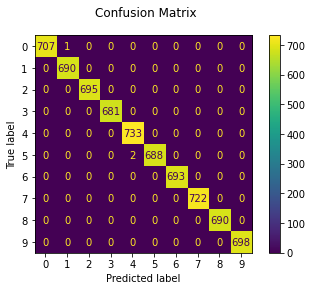

In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle


def classify(data_type):
    if data_type == "complex":
        x_data = x_complex
        y_data = y_complex
        n_samples, n_x, n_y = x_data.shape
        x_data = x_data.reshape((n_samples, -1))
        x_data = x_data / 255

        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.35, shuffle=True)

    else:
        X_train = X_train_simple
        n_samples, n_x, n_y = X_train.shape
        X_train = X_train.reshape((n_samples, -1))

        y_train = y_train_simple

        X_test = X_test_simple
        n_samples, n_x, n_y = X_test.shape
        X_test = X_test.reshape((n_samples, -1))

        y_test = y_test_simple


    # clf = svm.LinearSVC(dual=False)
    # clf = KNeighborsClassifier(n_neighbors=4)
    # clf = LinearSVC()
    clf = RandomForestClassifier()


    print("Fitting model...")
    clf.fit(X_train, y_train)

    print("Saving model...")
    pickle.dump(clf, open("handmodel.model", mode="wb"))

    print("Testing model...")
    predicted = clf.predict(X_test)

    # evaluate predictions
    acc = accuracy_score(y_test, predicted)
    print('Accuracy: %.3f' % acc)

    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y_test, predicted)}\n")

    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

    plt.show()

classify("complex")

## Messing around with Neural Networks
We tried some testing using neural networks below but it went unfinished.

In [ ]:
import torch.nn.functional as F

class HandGestureNet(nn.Module):
    def __init__(self):
        super(HandGestureNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

network = HandGestureNet()